<a href="https://colab.research.google.com/github/cedro3/data-efficient-gans/blob/master/DiffAugment_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data-Efficient GANs with DiffAugment


## セットアップ



In [1]:
# tensorflow 1.15.0　のインストール
!pip uninstall -y tensorflow tensorflow-probability
!pip install tensorflow-gpu==1.15.0 tensorflow-datasets==2.1.0

# Githubからコードをコピー
!git clone https://github.com/cedro3/data-efficient-gans.git

Cloning into 'data-efficient-gans'...
remote: Enumerating objects: 583, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 583 (delta 132), reused 130 (delta 130), pack-reused 444
Receiving objects: 100% (583/583), 31.77 MiB | 25.60 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [2]:
# ディレクトリをDiffAugment-stylegan2に移動
%cd data-efficient-gans/DiffAugment-stylegan2

/home/honda/デスクトップ/formula/image_base/data-efficient-gans/DiffAugment-stylegan2


In [3]:
# Google drive から新垣結衣の画像と学習済みの重みをダウンロード
import requests
import sys
import os
import zipfile

def download_file_from_google_drive(id, destination):

       # ダウンロード画面のURL
       URL = "https://drive.google.com/uc?id=1rlmCCuLH4euzIwzqlYh8LiF5iizh5UWV&export=download" 

       session = requests.Session()

       response = session.get(URL, params = { 'id' : id }, stream = True)
       token = get_confirm_token(response)

       if token:
           params = { 'id' : id, 'confirm' : token }
           response = session.get(URL, params = params, stream = True)

       save_response_content(response, destination)    

def get_confirm_token(response):
       for key, value in response.cookies.items():
           if key.startswith('download_warning'):
               return value

       return None

def save_response_content(response, destination):
       CHUNK_SIZE = 32768

       with open(destination, "wb") as f:
           for chunk in response.iter_content(CHUNK_SIZE):
               if chunk: # filter out keep-alive new chunks
                   f.write(chunk)

if __name__ == "__main__":

       file_id = 'TAKE ID FROM SHAREABLE LINK' 
       destination = './yui.zip'  # 保存先パスの指定
       download_file_from_google_drive(file_id, destination)

       # zipファイル解凍
       zipf = zipfile.ZipFile('./yui.zip')
       zipf.extractall()
       zipf.close()

# 関数の定義

In [4]:
# 関数の定義
import tensorflow as tf
import os
import numpy as np
import PIL
import IPython
from multiprocessing import Pool
import matplotlib.pyplot as plt

from dnnlib import tflib, EasyDict
from training import misc, dataset_tool
from metrics import metric_base
from metrics.metric_defaults import metric_defaults

def _generate(network_name, num_rows, num_cols, seed, resolution):
  if seed is not None:
    np.random.seed(seed)
  with tf.Session():
    _, _, Gs = misc.load_pkl(network_name)
    z = np.random.randn(num_rows * num_cols, Gs.input_shape[1])
    outputs = Gs.run(z, None, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))
    outputs = np.reshape(outputs, [num_rows, num_cols, *outputs.shape[1:]])
    outputs = np.concatenate(outputs, axis=1)
    outputs = np.concatenate(outputs, axis=1)
    img = PIL.Image.fromarray(outputs)
    img = img.resize((resolution * num_cols, resolution * num_rows), PIL.Image.ANTIALIAS)
  return img

def generate(network_name, num_rows, num_cols, seed=None, resolution=128):
  with Pool(1) as pool:
    return pool.apply(_generate, (network_name, num_rows, num_cols, seed, resolution))

# データセットの作成
64×64の画像100枚からtfrecords形式のデータセットを作成します。\

Loading images from "100-shot-gakki"
Creating dataset "100-shot-gakki"
Added 100 images.                       


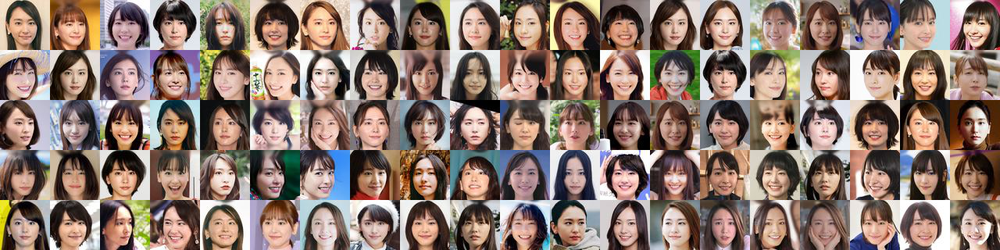

In [5]:
# 100-shot-gakki を読み込み学習用データセットを作成
data_dir = dataset_tool.create_dataset('100-shot-gakki')
training_images = []
for fname in os.listdir(data_dir):
  if fname.endswith('.jpg'):
    training_images.append(np.array(PIL.Image.open(os.path.join(data_dir, fname))))
imgs = np.reshape(training_images, [5, 20, *training_images[0].shape])
imgs = np.concatenate(imgs, axis=1)
imgs = np.concatenate(imgs, axis=1)
PIL.Image.fromarray(imgs).resize((1000, 250), PIL.Image.ANTIALIAS)

# 学習の実行
学習時間は、割り当てられているGPUによって異なります。下記を参考にして下さい。\ 
P100 : 7.3H (kimg=300)\
V100 : 4.1H (kimg=300)\
\
※割り当てがK80であったり、学習に時間を掛けたくない方は、kimg=500で学習した重みがありますので、ここはパスでOKです。

In [6]:
# GPUの確認
!nvidia-smi

Tue Jun 22 20:49:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
| 26%   60C    P0    66W / 250W |    613MiB / 11178MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# 学習の実行
!python3 run_few_shot.py --dataset=100-shot-gakki --resolution=64 --total-kimg=300

Local submit - run_dir: results/00000-DiffAugment-stylegan2-100-shot-gakki-64-batch16-1gpu-color-translation-cutout
dnnlib: Running training.training_loop.training_loop() on localhost...
2021-06-22 20:49:47.102711: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory
2021-06-22 20:49:47.102775: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shared object file: No such file or directory
2021-06-22 20:49:47.102827: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcufft.so.10.0'; dlerror: libcufft.so.10.0: cannot open shared object file: No such file or directory
2021-06-22 20:49:47.102874: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'l

# 学習済みの重みを使う
実際に学習を行った場合は、resultsフォルダーの1段下に重み( network-snapshot-XXXXXX.pkl)が作成されますので、それをDiffAugment-stylegan2のディレクトリーに移動して下さい。\
そして、**generate() , generate_gif.py** の引数をそのファイル名に変更して下さい。\
\

In [ ]:
# 学習済みの重みを使って画像生成
generate('network-snapshot-gakki-000500.pkl', num_rows=2, num_cols=5, seed=3)

In [ ]:
# 学習済みの重みを使って、GIF動画 (interp.gif) を作成
!python3 generate_gif.py -r network-snapshot-gakki-000500.pkl -o interp.gif --num-rows=2 --num-cols=3 --seed=1
IPython.display.Image(open('interp.gif', 'rb').read())